In [2]:
import numpy as np
import pandas as pd
from numpy import linalg
import matplotlib.pyplot as plt
import datetime
import time
from tqdm import tqdm
from scipy import stats
from tabulate import tabulate
from scipy.interpolate import make_interp_spline

In [3]:
# ENTER INPUTS
N = 1024000 #Number of simulations
NA = 3 #Number of assets

S10 = 25.0 # Halliburton
S20 = 126.85 # Valero
S30 = 109.02 # Exxon

# implied volatility at 100% moneyness
sigma1_100 = 0.35354 # Halliburton
sigma2_100 = 0.32416 # Valero
sigma3_100 = 0.23255 # Exxon

# implied volatility at 50% moneyness
sigma1_50 = 0.41170 # Halliburton
sigma2_50 = 0.38605 # Valero
sigma3_50 = 0.32691 # Exxon


# 2 year historical correlation
rho12 = 0.563 # Halliburton - Vallero
rho23 = 0.591 # Valero - Exxon
rho13 = 0.715 # Exxon - Halliburton

# creating forward rates
forward_rates = np.array([
    0.0411,  # June 9, 2025
    0.0404,  # September 8, 2025
    0.0378,  # December 8, 2025
    0.0362,  # March 9, 2026
    0.0352,  # June 8, 2026
    0.0355,  # September 8, 2026
    0.0350,  # December 7, 2026
    0.0353   # March 8, 2027
])


q1 = 0.02904 # dividend yield for Halliburton
q2 = 0.03724 # dividend yield for Valero Energy
q3 = 0.038870 # dividend yield for Exxon Mobil

T = 2.0 # time in years
M = T*365 # time steps
prin = 1000.0 # principal
coupon = 25.775 # contingent coupon

# pricing date
pricing_date = datetime.date(2025, 3, 7)

# issue date
issue_date = datetime.date(2025, 3, 12)

# maturity date
maturity_date = datetime.date(2027, 3, 11)

# Define exact determination dates
determination_dates = [
    datetime.date(2025, 6, 9),    # June 9, 2025
    datetime.date(2025, 9, 8),    # September 8, 2025
    datetime.date(2025, 12, 8),   # December 8, 2025
    datetime.date(2026, 3, 9),    # March 9, 2026
    datetime.date(2026, 6, 8),    # June 8, 2026
    datetime.date(2026, 9, 8),    # September 8, 2026
    datetime.date(2026, 12, 7),   # December 7, 2026
    datetime.date(2027, 3, 8)     # March 8, 2027
]

# Convert to year fractions (Actual/365 convention)
det_dates = np.array([
      (date - issue_date).days / 365.0 for date in determination_dates
])

D = 8 # number of determination dates

# Contingent payment dates
contingent_payment_dates = [
    datetime.date(2025, 6, 12),    # June 12, 2025
    datetime.date(2025, 9, 11),    # September 11, 2025
    datetime.date(2025, 12, 11),   # December 11, 2025
    datetime.date(2026, 3, 12),    # March 12, 2026
    datetime.date(2026, 6, 11),    # June 11, 2026
    datetime.date(2026, 9, 11),    # September 11, 2026
    datetime.date(2026, 12, 10),   # December 10, 2026
    datetime.date(2027, 3, 11)      # Maturity date
]

# Convert to year fractions (Actual/365 convention)
cont_dates = np.array([
    (date - issue_date).days / 365.0 for date in contingent_payment_dates
])

# call threshold level
call_thresholds = np.array([25.0,126.85,109.02])

# coupon barrier/downside threshold level
coupon_barriers = np.array([12.50,63.43,54.51])

# calculating discount factors
# Create an array with 0 at the beginning and the det_dates
all_dates = np.insert(det_dates, 0, 0)
# Calculate time intervals between consecutive dates
time_intervals = np.diff(all_dates)
# Calculate discount factors for each interval
discount = np.ones(len(time_intervals))
for i in range(len(time_intervals)):
    discount[i] = np.exp(-forward_rates[i] * time_intervals[i])
discount

array([0.99002841, 0.98997823, 0.99062016, 0.9910154 , 0.99126251,
       0.99109197, 0.991407  , 0.99123779])

In [4]:
S0 = np.array([S10, S20, S30])
sigma_100 = [sigma1_100, sigma2_100, sigma3_100]
sigma_50 = [sigma1_50, sigma2_50, sigma3_50]
q = [q1, q2, q3]
rho = [[1, rho12, rho13],[rho12, 1, rho23],[rho13, rho23, 1]]
rho

[[1, 0.563, 0.715], [0.563, 1, 0.591], [0.715, 0.591, 1]]

In [5]:
# Cholesky decomposition
C = np.linalg.cholesky(rho)
C

array([[1.        , 0.        , 0.        ],
       [0.563     , 0.8264569 , 0.        ],
       [0.715     , 0.22802762, 0.66089213]])

In [6]:
# generate stock price 3D matrix
def MC_StockPrices(N, NA, S0, r, q, sigma, rho, det_dates):

    S = np.zeros([N, len(det_dates), NA]) # stock prices will have three indices - path, det date, asset
    drift = np.zeros([NA+1])
    S0 = np.array(S0)
    q = np.array(q)
    sigma = np.array(sigma)

    for i in range(0, N): # loop through paths
        phi = []
        current_prices_primary = np.array(S0.copy())  # Start with initial prices

        for d_idx,det_date in enumerate(det_dates): #looping through determination dates
            if d_idx == 0:
              time_step = det_date # first time step is from 0 to first det_date
            else:
              time_step = det_date - det_dates[d_idx-1] # time step is from previous det_date to current det_date

            current_r = r[d_idx]
            # generate correlated random variables
            phi = np.random.normal(0,1,NA)
            diffusion_vec = np.matmul(C,phi)

            # generate stock price for each asset
            for j in range(NA):
              #q_val = [q1, q2, q3][j]  # Get correct dividend yield
              #sigma_val = [sigma1, sigma2, sigma3][j]  # Get correct volatility

              drift_term = (current_r - q[j] - 0.5 * sigma[j]**2) * time_step
              diffusion_term = sigma[j] * np.sqrt(time_step) * diffusion_vec[j]

              current_prices_primary[j] *= np.exp(drift_term + diffusion_term)

            S[i, d_idx, :] = current_prices_primary # storing the prices at this determination date for all assets

    return S

In [7]:
# Valuation function
def value(S0,S,r, D, det_dates, cont_dates, call_thresholds, coupon_barriers, prin, coupon, discount):

    cont_value = np.zeros([N, len(det_dates)]) # defining an array for storing the continuation value
    V = np.zeros([N, len(det_dates)]) # defining an array for storing the value

    for i in range(N):
      # At maturity
      if S[i, len(det_dates)-1, 0] >= coupon_barriers[0] and S[i, len(det_dates)-1, 1] >= coupon_barriers[1] and S[i, len(det_dates)-1, 2] >= coupon_barriers[2]:
        coup_disc_delay = cont_dates[-1] - det_dates[-1]
        coup_disc_mat = np.exp(-r[-1] * coup_disc_delay) # calculate discount factor for coupon
        V[i, len(det_dates)-1] = (prin + coupon)*coup_disc_mat
      else:
        min_perf = min(S[i, len(det_dates)-1, 0]/S0[0], S[i, len(det_dates)-1, 1]/S0[1], S[i, len(det_dates)-1, 2]/S0[2])
        V[i, len(det_dates)-1] = prin * min_perf

    # At each determination date
    for i in range(len(det_dates)-2,-1,-1): # for the dates
      for n in range(N): # for each path

        cont_value[n,i] = discount[i+1] * V[n, i+1] # continuation value

        coupon_delay = cont_dates[i] - det_dates[i]
        coupon_discount = np.exp(-r[i] * coupon_delay) # calculate discount factor for coupon

        # checking for early redemption
        if S[n, i, 0] >= call_thresholds[0] and S[n, i, 1] >= call_thresholds[1] and S[n, i, 2] >= call_thresholds[2]:
          V[n, i] = (prin + coupon) * coupon_discount

        # checking for contingent coupon payment
        elif S[n,i,0] >= coupon_barriers[0] and S[n,i,1] >= coupon_barriers[1] and S[n,i,2] >= coupon_barriers[2]:
          V[n, i] = cont_value[n,i] + coupon * coupon_discount
        else: V[n, i] = cont_value[n,i]

    # Calculate the standard error
    path_values = V[:, 0] * discount[0]
    std_error = np.std(path_values, ddof=1) / np.sqrt(N)

    return np.mean(V[:,0]) * discount[0], std_error


In [7]:
simulation = 10

# Initialize array to store values
values_100,values_50 = np.zeros(simulation), np.zeros(simulation)
stderror_100,stderror_50 = np.zeros(simulation), np.zeros(simulation)

# Run simulations
for i in range(simulation):
    S_100 = MC_StockPrices(N, NA, S0, forward_rates, q, sigma_100, rho, det_dates)
    Value_100, stderror100 = value(S0, S_100, forward_rates, D, det_dates, cont_dates, call_thresholds, coupon_barriers, prin, coupon, discount)
    values_100[i] = Value_100
    stderror_100[i] = stderror100
    S_50 = MC_StockPrices(N, NA, S0, forward_rates, q, sigma_50, rho, det_dates)
    Value_50, stderror50 = value(S0, S_50, forward_rates, D, det_dates, cont_dates, call_thresholds, coupon_barriers, prin, coupon, discount)
    values_50[i] = Value_50
    stderror_50[i] = stderror50

# Calculate mean values and standard errors
mean_value_100 = np.mean(values_100)
mean_stderr_100 = np.mean(stderror_100)
stderr_of_mean_100 = np.std(values_100, ddof=1) / np.sqrt(simulation)

mean_value_50 = np.mean(values_50)
mean_stderr_50 = np.mean(stderror_50)
stderr_of_mean_50 = np.std(values_50, ddof=1) / np.sqrt(simulation)

# Print statistics
print("Note value at 100% Moneyness:")
print(f"Mean: {mean_value_100:.2f}")
print(f"Average Standard Error (within simulations): {mean_stderr_100:.4f}")
print()

print("Note value at 50% Moneyness:")
print(f"Mean: {mean_value_50:.2f}")
print(f"Average Standard Error (within simulations): {mean_stderr_50:.4f}")





Note value at 100% Moneyness:
Mean: 980.98
Average Standard Error (within simulations): 0.2115

Note value at 50% Moneyness:
Mean: 924.83
Average Standard Error (within simulations): 0.2594


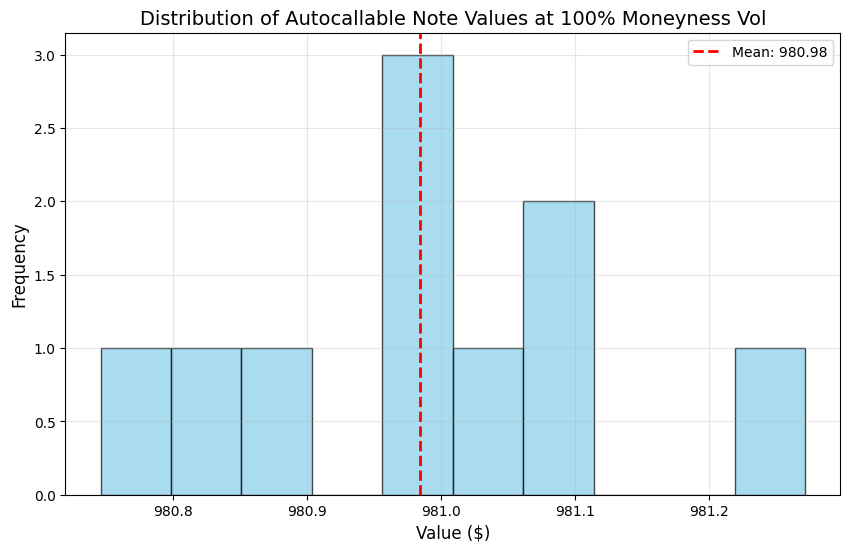

In [8]:
# Plot histogram with mean instead of mode
plt.figure(figsize=(10, 6))

# Calculate histogram data
counts, bin_edges = np.histogram(values_100, bins=10)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# Calculate mean
mean_value_100 = np.mean(values_100)

# Plot the histogram
plt.hist(values_100, bins=bin_edges, alpha=0.7, color='skyblue', edgecolor='black')

# Add line for mean
plt.axvline(mean_value_100, color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {mean_value_100:.2f}')

plt.title('Distribution of Autocallable Note Values at 100% Moneyness Vol', fontsize=14)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

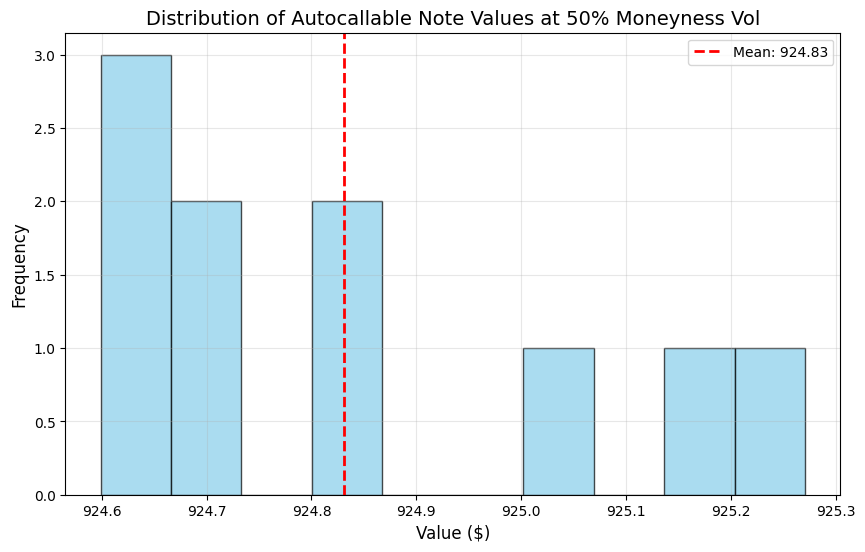

In [9]:
# Plot histogram with mean instead of mode
plt.figure(figsize=(10, 6))

# Calculate histogram data
counts, bin_edges = np.histogram(values_50, bins=10)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# Calculate mean
mean_value_50 = np.mean(values_50)

# Plot the histogram
plt.hist(values_50, bins=bin_edges, alpha=0.7, color='skyblue', edgecolor='black')

# Add line for mean
plt.axvline(mean_value_50, color='red', linestyle='dashed', linewidth=2,
            label=f'Mean: {mean_value_50:.2f}')

plt.title('Distribution of Autocallable Note Values at 50% Moneyness Vol', fontsize=14)
plt.xlabel('Value ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [10]:
# calculating final value
final_value = (mean_value_100 + mean_value_50) / 2
print(f"Final value of the note: {final_value:.2f}")

Final value of the note: 952.91


In [8]:
# Define the simulation sizes
simulation_sizes = []
size = 1000
while size <= 1200000:
    simulation_sizes.append(size)
    size *= 2

# Initialize results storage for both moneyness levels
results_50 = []
results_100 = []

print("Running simulations...")
for n_sim in simulation_sizes:
    start_time = time.time()

    # Set N for the simulation
    N = n_sim

    # Run the simulation for 50% moneyness
    S_50 = MC_StockPrices(N, NA, S0, forward_rates, q, sigma_50, rho, det_dates)
    price_50, std_error_50 = value(S0, S_50, forward_rates, D, det_dates, cont_dates,
                           call_thresholds, coupon_barriers, prin, coupon, discount)

    # Record elapsed time for 50% moneyness
    elapsed_time_50 = time.time() - start_time

    # Store results for 50% moneyness
    results_50.append([n_sim, price_50, std_error_50, elapsed_time_50])

    # Reset start time for 100% moneyness
    start_time = time.time()

    # Run the simulation for 100% moneyness
    S_100 = MC_StockPrices(N, NA, S0, forward_rates, q, sigma_100, rho, det_dates)
    price_100, std_error_100 = value(S0, S_100, forward_rates, D, det_dates, cont_dates,
                             call_thresholds, coupon_barriers, prin, coupon, discount)

    # Record elapsed time for 100% moneyness
    elapsed_time_100 = time.time() - start_time

    # Store results for 100% moneyness
    results_100.append([n_sim, price_100, std_error_100, elapsed_time_100])

    print(f"Completed {n_sim:,} simulations:")
    print(f"  50% Moneyness: {price_50:.2f}")
    print(f"  100% Moneyness: {price_100:.2f}")

# Convert results to numpy arrays for easier handling
results_50_array = np.array(results_50)
results_100_array = np.array(results_100)

# Display results in nice tables
headers = ["Simulations", "Price ($)", "Std Error ($)", "Time (s)"]

print("\nConvergence Analysis for 50% Moneyness:")
table_50 = tabulate(results_50, headers=headers, tablefmt="grid",
                  floatfmt=(",d", ".2f", ".4f", ".2f"))
print(table_50)

print("\nConvergence Analysis for 100% Moneyness:")
table_100 = tabulate(results_100, headers=headers, tablefmt="grid",
                   floatfmt=(",d", ".2f", ".4f", ".2f"))
print(table_100)

Running simulations...
Completed 1,000 simulations:
  50% Moneyness: 938.44
  100% Moneyness: 975.01
Completed 2,000 simulations:
  50% Moneyness: 920.69
  100% Moneyness: 986.21
Completed 4,000 simulations:
  50% Moneyness: 927.50
  100% Moneyness: 981.71
Completed 8,000 simulations:
  50% Moneyness: 928.98
  100% Moneyness: 980.50
Completed 16,000 simulations:
  50% Moneyness: 925.57
  100% Moneyness: 980.46
Completed 32,000 simulations:
  50% Moneyness: 925.64
  100% Moneyness: 981.68
Completed 64,000 simulations:
  50% Moneyness: 926.68
  100% Moneyness: 981.73
Completed 128,000 simulations:
  50% Moneyness: 925.39
  100% Moneyness: 980.79
Completed 256,000 simulations:
  50% Moneyness: 924.67
  100% Moneyness: 981.37
Completed 512,000 simulations:
  50% Moneyness: 925.52
  100% Moneyness: 981.15
Completed 1,024,000 simulations:
  50% Moneyness: 925.03
  100% Moneyness: 981.34

Convergence Analysis for 50% Moneyness:
+---------------+-------------+-----------------+------------+
| 

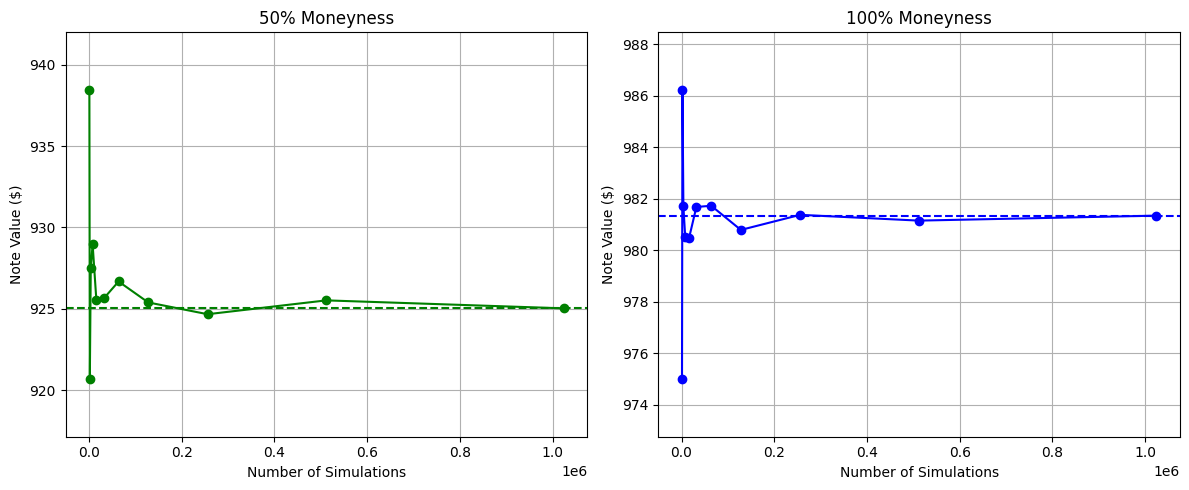

In [9]:
# Simple separate plots for 50% and 100% moneyness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get data for plotting
sim_sizes = results_50_array[:, 0]
prices_50 = results_50_array[:, 1]
prices_100 = results_100_array[:, 1]

# 1. Plot for 50% Moneyness
ax1.plot(sim_sizes, prices_50, '-o', color='green')
ax1.axhline(y=prices_50[-1], color='green', linestyle='--')
ax1.set_title('50% Moneyness')
ax1.set_xlabel('Number of Simulations')
ax1.set_ylabel('Note Value ($)')
ax1.grid(True)

# Custom y-axis limits for 50% Moneyness
y_mean_50 = np.mean(prices_50)
y_range_50 = max(prices_50) - min(prices_50)
buffer = y_range_50 * 0.2  # Add 20% buffer
ax1.set_ylim(min(prices_50) - buffer, max(prices_50) + buffer)

# 2. Plot for 100% Moneyness
ax2.plot(sim_sizes, prices_100, '-o', color='blue')
ax2.axhline(y=prices_100[-1], color='blue', linestyle='--')
ax2.set_title('100% Moneyness')
ax2.set_xlabel('Number of Simulations')
ax2.set_ylabel('Note Value ($)')
ax2.grid(True)

# Custom y-axis limits for 100% Moneyness
y_mean_100 = np.mean(prices_100)
y_range_100 = max(prices_100) - min(prices_100)
buffer = y_range_100 * 0.2  # Add 20% buffer
ax2.set_ylim(min(prices_100) - buffer, max(prices_100) + buffer)

plt.tight_layout()
plt.show()